# **Modelo de Clasificación**

### **Importación de librerías**

In [5]:
import joblib
import numpy as np
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

### **Cargar datasets**

In [6]:
train_df = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'train.csv'))
test_df = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'test.csv'))

In [7]:
# Excluir las columnas "Title" y "Dimensions"
train_df = train_df.drop(columns = ['Title', 'Dimensions'])
test_df = test_df.drop(columns = ['Title', 'Dimensions'])

Tras cargar los datos se excluyen las columnas "Title" y "Dimensions", ya que en el EDA se llegó a la conclusión de que tenían una cardinalidad muy alta y eran unas columnas demasiado específicas y, por lo tanto, no serían útiles para el modelado.

### **Preprocesamiento de los datos**

In [8]:
# Crear X e y
X_train = train_df.drop('Is Highlight', axis = 1)
y_train = train_df['Is Highlight']

X_test = test_df.drop('Is Highlight', axis = 1)
y_test = test_df['Is Highlight']

In [9]:
# Establecer target y features categóricas y numéricas
target = 'Is Highlight'

cat_features = X_train.select_dtypes(include = ['object', 'bool']).columns.tolist()

num_features = X_train.select_dtypes(include = ['number']).columns.tolist()

Se va a utilizar pipeline para preprocesar los datos, utilizándose para la estandarización de las numéricas el "StandarScaler" y para la codificación de las categóricas el "OneHotEncoder".

In [10]:
# Pipeline para preprocesar las características numéricas
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

In [11]:
# Pipeline para preprocesar las características categóricas
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [12]:
# Combinar los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [13]:
# Aplicar el preprocesador a los datos
X_train_preprocessor = preprocessor.fit_transform(X_train)
X_test_preprocessor = preprocessor.transform(X_test)

A continuación, se procederá a la selección de características con la ayuda de "SelectKBest", el cual seleccionará las "k" mejores características, basadas en una función de puntuación que mide la relación de cada característica con la variable objetivo.

In [14]:
selector = SelectKBest(score_func = f_classif, k = 20)
X_train_selector = selector.fit_transform(X_train_preprocessor, y_train)
X_test_selector = selector.transform(X_test_preprocessor)

### **Rebalanceo**

En un primer momento, se hace el entrenamiento, optimización y evaluación del modelo sin utilizar ninguna técnica, y con ello se presenta el problema de que la clase minoritaria (True) tiene una precisión casi nula debido a que el target está muy desbalanceado. Por lo tanto, se procederá a utilizar dos técnicas para mejorar el rendimiento del modelo. Estas técnicas son:  
- **SMOTE:** Se utiliza para aumentar el número de ejemplos de la clase minoritaria, creando ejemplos sintéticos en lugar de duplicar los existentes.
- **Class Weights:** Asigna pesos diferentes a las clases en función de su frecuencia.

In [15]:
# SMOTE
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selector, y_train)

In [16]:
# Class Weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.array([False, True]), y = y_train_smote)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

### **Crear y entrenar el modelo**

In [17]:
# Escoger y probar todos los modelos de clasificación
model_names = ["Logistic Regression", "DecisionTree", "Random Forest", "XGBoost", "LightGBM", "CatBoost"]

lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state = 42)
rf_clf = RandomForestClassifier(random_state = 42)
xgb_clf = XGBClassifier(random_state = 42)
lgbm_clf = LGBMClassifier(random_state = 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state = 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgbm_clf, cat_clf]

In [18]:
# Comprar con validación cruzada
metrics_cv = {}
values = []
for name, model in zip(model_names, model_set):
    print(model)
    if name != "Logistic Regression":
        metrics_cv[name] = cross_val_score(model, X_train_smote, y_train_smote, cv = 3, scoring = "accuracy")
    else:
        metrics_cv[name] = cross_val_score(model, X_train_smote, y_train_smote, cv = 3, scoring = "accuracy")
    values.append(np.mean(metrics_cv[name]))
winner = list(metrics_cv.keys())[np.argmax(values)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)


In [19]:
for model_name, values in metrics_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(values)}")
print(f"El ganador es {winner}")

Model <Logistic Regression>, Accuracy_CV: 0.8462391429692206
Model <DecisionTree>, Accuracy_CV: 0.8470457240556533
Model <Random Forest>, Accuracy_CV: 0.8470534351499439
Model <XGBoost>, Accuracy_CV: 0.8470688573527959
Model <LightGBM>, Accuracy_CV: 0.8470596040482095
Model <CatBoost>, Accuracy_CV: 0.8470534351428086
El ganador es XGBoost


Como se puede comprobar, el modelo que mejores resultados nos daría es XGBoost.  
Sin embargo, como todos los resultados están muy ajustados, vamos a optimizar, entrenar y evaluar todos los modelos para ver cuál de ellos da el mejor resultado realmente. Incluso, para mayor fiabilidad, combinaremos todos los modelos de manera individual a través del Ensemble Learning para ver si podemos obtener un mejor rendimiento si cabe.

### **Optimización de los modelos**

**Logistic Regression**

In [20]:
params_grid_lr = {
    "penalty" : ["l1", "l2", "elasticnet", "none"],
    "C" : [0.01, 0.1, 1, 10, 100],
    "solver" : ["lbfgs", "liblinear", "saga"],
    "max_iter" : [50, 100, 200]
}

lr_grid = GridSearchCV(lr_clf,
                       param_grid = params_grid_lr,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

lr_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [50, 100, 200],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [21]:
lr_best_params = lr_grid.best_params_
lr_best_params

{'C': 100, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

**Decision Tree**

In [22]:
params_grid_tree = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_depth" : [None, 10, 20, 30],
    "min_samples_split" : [1, 2, 3],
    "min_samples_leaf" : [0.5, 1, 2],
    "max_features" : [None, "sqrt", "log2"]
}

tree_grid = GridSearchCV(tree_clf,
                        param_grid = params_grid_tree,
                        cv = 3,
                        scoring = "accuracy",
                        n_jobs = -1)

tree_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [0.5, 1, 2],
                         'min_samples_split': [1, 2, 3],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [23]:
tree_best_params = tree_grid.best_params_
tree_best_params

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}

**Random Forest**

In [24]:
params_grid_rf = {
    "n_estimators" : [200, 300, 400],
    "max_depth" : [None, 10, 20, 30],
    "min_samples_leaf" : [0.5, 1, 2],
    "max_features" : [None, "sqrt", "log2"],
    "max_samples" : [0.5, 0.75, 1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid = params_grid_rf,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_samples': [0.5, 0.75, 1],
                         'min_samples_leaf': [0.5, 1, 2],
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy')

In [25]:
rf_best_params = rf_grid.best_params_
rf_best_params

{'max_depth': None,
 'max_features': 'sqrt',
 'max_samples': 0.75,
 'min_samples_leaf': 1,
 'n_estimators': 300}

**XGBoost**

In [26]:
params_grid_xgb = {
    "n_estimators" : [200, 300, 400],
    "max_depth" : [1, 3, 5],
    "learning_rate" : [0.1, 0.2, 0.3],
    "subsample" : [0.1, 0.5, 1],
    "colsample_bytree" : [0.05, 0.1, 0.2],
    "gamma" : [0, 1, 2]
}

xgb_grid = GridSearchCV(xgb_clf,
                       param_grid = params_grid_xgb,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

xgb_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.05, 0.1, 0.2],
                         'gamma': [0, 1, 2], 'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [200, 300, 400],
                         'subsample': [0.1, 0.5, 1]},
             scoring='accuracy')

In [27]:
xgb_best_params = xgb_grid.best_params_
xgb_best_params

{'colsample_bytree': 0.1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.5}

**LightGBM**

In [28]:
params_grid_lgbm = {
    "n_estimators" : [200, 300, 400],
    "max_depth" : [3, 5, 7],
    "learning_rate" : [0.01, 0.05, 0.1],
    "num_leaves" : [5, 10, 15],
    "subsample" : [0.1, 0.2, 0.3],
    "colsample_bytree" : [0.1, 0.2, 0.3]
}

lgbm_grid = GridSearchCV(lgbm_clf,
                        param_grid = params_grid_lgbm,
                        cv = 3,
                        scoring = "accuracy",
                        n_jobs = -1)

lgbm_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42, verbose=-100),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.1, 0.2, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [200, 300, 400],
                         'num_leaves': [5, 10, 15],
                         'subsample': [0.1, 0.2, 0.3]},
             scoring='accuracy')

In [29]:
lgbm_best_params = lgbm_grid.best_params_
lgbm_best_params

{'colsample_bytree': 0.2,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 300,
 'num_leaves': 10,
 'subsample': 0.1}

**CatBoost**

In [30]:
params_grid_cat = {
    "iterations" : [25, 50, 75],
    "depth" : [1, 2, 3],
    "learning_rate" : [0.3, 0.5, 0.7],
    "l2_leaf_reg" : [0.01, 0.05, 0.1],
    "border_count" : [3, 5, 7],
    "thread_count" : [-1]
}

cat_grid = GridSearchCV(cat_clf,
                        param_grid = params_grid_cat,
                        cv = 3,
                        scoring = "accuracy",
                        n_jobs = -1)

cat_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001997F52A440>,
             n_jobs=-1,
             param_grid={'border_count': [3, 5, 7], 'depth': [1, 2, 3],
                         'iterations': [25, 50, 75],
                         'l2_leaf_reg': [0.01, 0.05, 0.1],
                         'learning_rate': [0.3, 0.5, 0.7],
                         'thread_count': [-1]},
             scoring='accuracy')

In [31]:
cat_best_params = cat_grid.best_params_
cat_best_params

{'border_count': 5,
 'depth': 2,
 'iterations': 50,
 'l2_leaf_reg': 0.05,
 'learning_rate': 0.5,
 'thread_count': -1}

**Ensemble Learning**

In [32]:
# Crear los modelos base
lr_clf_ensemble = LogisticRegression(class_weight = class_weight_dict, max_iter = 200)
tree_clf_ensemble = DecisionTreeClassifier(**tree_best_params, class_weight = class_weight_dict)
rf_clf_ensemble = RandomForestClassifier(**rf_best_params, class_weight = class_weight_dict)
xgb_clf_ensemble = XGBClassifier(**xgb_best_params, scale_pos_weight = class_weight_dict[1] / class_weight_dict[0])
lgbm_clf_ensemble = LGBMClassifier(**lgbm_best_params, class_weight = class_weight_dict)
cat_clf_ensemble = CatBoostClassifier(**cat_best_params, class_weights = [class_weight_dict[0], class_weight_dict[1]])

In [33]:
# Crear y entrenar el ensemble
ensemble_clf = VotingClassifier(estimators = [
    ('logistic_regression', lr_clf_ensemble),
    ('decision_tree', tree_clf_ensemble),
    ('random_forest', rf_clf_ensemble),
    ('xgboost', xgb_clf_ensemble),
    ('lightgbm', lgbm_clf_ensemble),
    ('catboost', cat_clf_ensemble)    
], voting = 'soft')

ensemble_clf.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 324208, number of negative: 324208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 648416, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(class_weight={0: 1.0, 1: 1.0},
                                                 max_iter=200)),
                             ('decision_tree',
                              DecisionTreeClassifier(class_weight={0: 1.0,
                                                                   1: 1.0},
                                                     criterion='entropy',
                                                     splitter='random')),
                             ('random_forest',
                              RandomForestClassifier(class_weight={0: 1.0,
                                                                   1: 1.0},
                                                     max_samples=0.75,
                                                     n_estimators=300)),
                             ('xgboost',
                              XGBClassifier(ba...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lightgbm',
                              LGBMClassifier(class_weight={0: 1.0, 1: 1.0},
                                             colsample_bytree=0.2,
                                             learning_rate=0.05, max_depth=5,
                                             n_estimators=300, num_leaves=10,
                                             subsample=0.1)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x000001997F52BAF0>)],
                 voting='soft')

### **Evaluación de los modelos**

**Logistic Regression**

In [34]:
y_pred_lr = lr_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.70      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.84      0.59     81500
weighted avg       0.99      0.97      0.98     81500



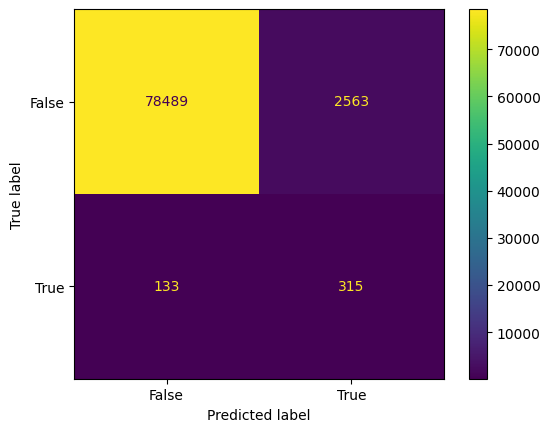

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr);

**Decision Tree**

In [36]:
y_pred_tree = tree_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.69      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.58     81500
weighted avg       0.99      0.97      0.98     81500



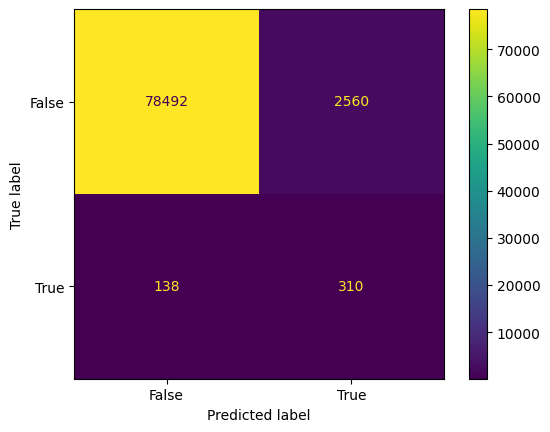

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree);

**Random Forest**

In [38]:
y_pred_rf = rf_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.69      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.58     81500
weighted avg       0.99      0.97      0.98     81500



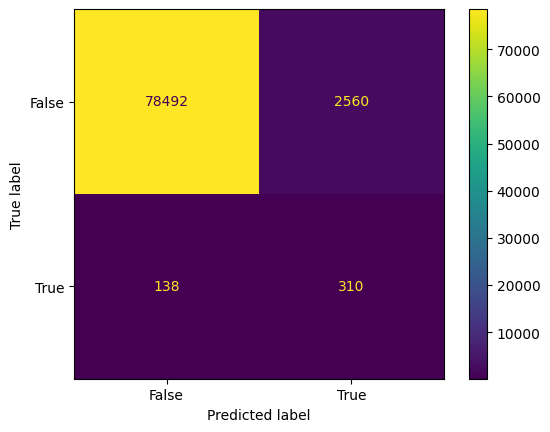

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf);

**XGBoost**

In [40]:
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.70      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.59     81500
weighted avg       0.99      0.97      0.98     81500



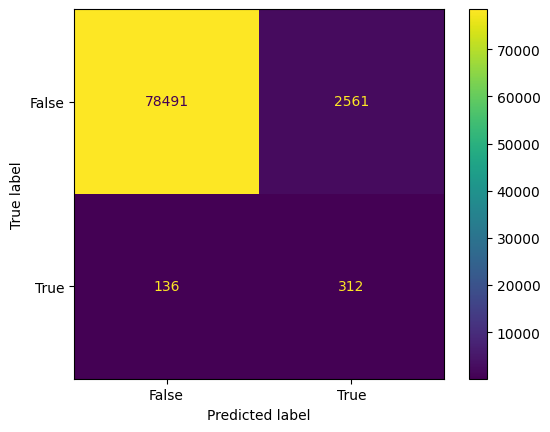

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb);

**LightGBM**

In [42]:
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.70      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.59     81500
weighted avg       0.99      0.97      0.98     81500



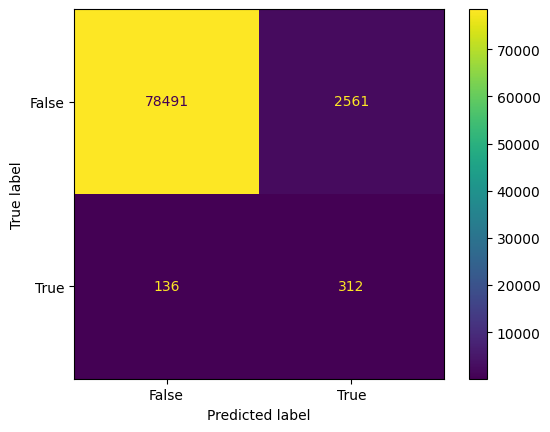

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm);

**CatBoost**

In [44]:
y_pred_cat = cat_grid.best_estimator_.predict(X_test_selector)
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.69      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.59     81500
weighted avg       0.99      0.97      0.98     81500



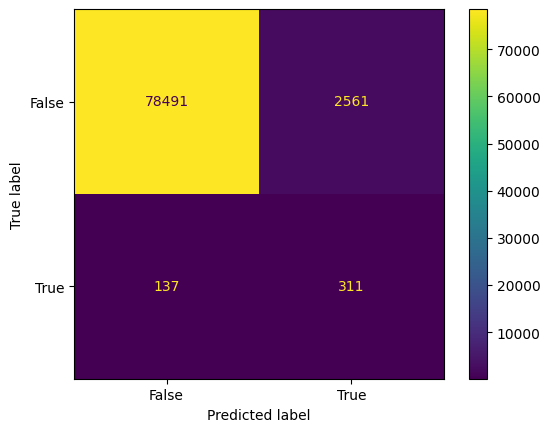

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cat);

**Ensemble Learning**

In [46]:
y_pred_ensemble = ensemble_clf.predict(X_test_selector)
print(classification_report(y_test, y_pred_ensemble))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98     81052
        True       0.11      0.70      0.19       448

    accuracy                           0.97     81500
   macro avg       0.55      0.83      0.59     81500
weighted avg       0.99      0.97      0.98     81500



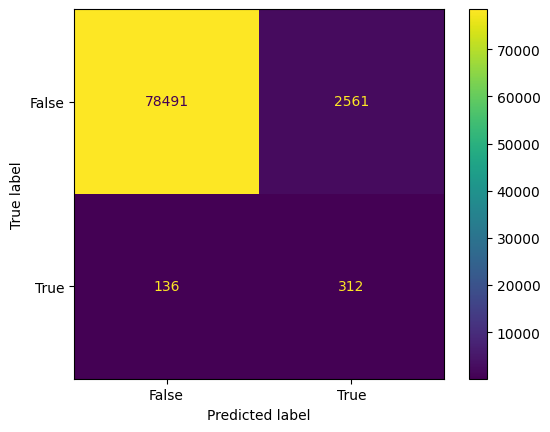

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ensemble);

Se puede concluir lo siguiente:
- Todos los modelos tienen un buen balance entre precisión y recall para la clase mayoritaria (False).
- El recall para la clase minoritaria (True) ha mejorado significativamente, con respecto al entrenamiento sin el uso de las técnicas de rebalanceo, pero aun así la precisión sigue siendo baja.
- La baja precisión para la clase minoritaria (True) indica que los modelos están generando muchos falsos positivos, lo que podría ser debido al propio dataset.

En cuanto a la elección de un modelo u otro, todos tienen un rendimiento similar, por lo que la elección del modelo puede depender de otros factores como el tiempo de entrenamiento, interpretabilidad y recursos computacionales.

En este caso utilizaremos XGBoost Classifier (Extreme Gradient Boosting Classifier).

In [48]:
# Guardar componentes y modelo
joblib.dump(preprocessor, os.path.join(os.getcwd(), '..', 'modelos', 'preprocessor.pkl'))
joblib.dump(selector, os.path.join(os.getcwd(), '..', 'modelos', 'selector.pkl'))
joblib.dump(xgb_grid, os.path.join(os.getcwd(), '..', 'modelos', 'modelo_xgb.pkl'))

['c:\\Users\\albam\\Desktop\\Proyecto_ML\\notebooks\\..\\modelos\\modelo_xgb.pkl']